### Figuring out how to apply gains to a matrix

In [1]:
import numpy as np
import cupy as cp
from typing import Sequence

ModuleNotFoundError: No module named 'numpy'

In [2]:
arr = np.arange(20)
print(arr)
print(arr[1::3])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 1  4  7 10 13 16 19]


In [3]:
g = np.ones(9)
print(g)
print(np.atleast_2d(g))


[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1. 1. 1. 1. 1. 1. 1. 1. 1.]]


NOTE: I can't seem to figure out why the build baseline array doesn't just subtract antenna positions. Ie. why the extra ant_1_array etc... 

In [4]:
def build_baseline_array(
    ant_1_array: np.ndarray,
    ant_2_array: np.ndarray,
    antpos: np.ndarray,
    antnums: Sequence,
):
    """Calculate all the baseline vectors for the provided parameters.

    Parameters
    ----------
    ant_1_array
        Array specifying the first antenna in each baseline.
    ant_2_array
        Array specifying the second antenna in each baseline.
    antpos
        Array with shape (Nants, 3) giving the ENU position, in meters, of
        each antenna in the array.
    antnums
        Iterable giving the number of each antenna in the order that the terms
        of ``antpos`` appear.

    Returns
    -------
    baselines
        Array with shape (Nbls, 3) giving all of the baselines for the provided
        parameters. This is calculated using the convention that the baseline
        is formed by subtracting the position of antenna 1 from the position of
        antenna 2, i.e. :math:`b_{ij} = x_j - x_i`.
    """
    ant_1_inds = np.zeros_like(ant_1_array)
    ant_2_inds = np.zeros_like(ant_2_array)
    for i, ant in enumerate(antnums):
        ant_1_inds[ant_1_array == ant] = i
        ant_2_inds[ant_2_array == ant] = i
    return antpos[ant_2_inds] - antpos[ant_1_inds]

In [5]:
ant1 = np.arange(10)[1:]
ant2 = np.arange(10)[1:]
print(ant1)

[1 2 3 4 5 6 7 8 9]


In [6]:
ar = np.array([1+1j, 2+2j])
print(ar[:])
print(ar.conj())

[1.+1.j 2.+2.j]
[1.-1.j 2.-2.j]


In [7]:
test_ar = np.arange(4)
new_ar = np.arange(8)[4:]
print(test_ar)
print(test_ar[:, None])
print(new_ar)
print()
print(test_ar * new_ar)
print(test_ar[:, None] * new_ar)

[0 1 2 3]
[[0]
 [1]
 [2]
 [3]]
[4 5 6 7]

[ 0  5 12 21]
[[ 0  0  0  0]
 [ 4  5  6  7]
 [ 8 10 12 14]
 [12 15 18 21]]


In [8]:
length = 6
ant_1_array = np.arange(int(length/2))
ant_2_array = np.arange(int(length / 2), int(length))
print(ant_1_array)
print(ant_2_array)


gains = np.arange(1, 2* length + 1)
c_gains = gains[::2] + 1j*gains[1::2]
print(gains)
print()
print(c_gains)
print(f"cplex gains shape {c_gains.shape}")


[0 1 2]
[3 4 5]
[ 1  2  3  4  5  6  7  8  9 10 11 12]

[ 1. +2.j  3. +4.j  5. +6.j  7. +8.j  9.+10.j 11.+12.j]
cplex gains shape (6,)


In [9]:
print(c_gains[ant_1_array, None])
print()
print(c_gains[ant_2_array, None])
print()
# print(c_gains[0, None] * c_gains[3].conj())

# print(
#     c_gains[ant_1_array, None] * c_gains[None, ant_1_array].conj() 
# )

print()
gain_mat = c_gains[ant_1_array, None] * c_gains[ant_2_array, None].conj() 
print(gain_mat)
print(gain_mat.real)
# print(gain_mat[1].imag)

mat = np.random.rand(2*gain_mat.shape[0], 5) #only works like this for real imag split in the mat
# print(mat)
print(mat[::2])
# print(mat[::2].shape)
# print((gain_mat.imag.shape))
out = np.zeros_like(mat)
# print(out.shape)
out[::2] = gain_mat.real * mat[::2] - gain_mat.imag * mat[1::2]
out[1::2] = gain_mat.imag * mat[::2] + gain_mat.real * mat[1::2]
print()
# print(out)

[[1.+2.j]
 [3.+4.j]
 [5.+6.j]]

[[ 7. +8.j]
 [ 9.+10.j]
 [11.+12.j]]


[[ 23.+6.j]
 [ 67.+6.j]
 [127.+6.j]]
[[ 23.]
 [ 67.]
 [127.]]
[[0.07454335 0.9153606  0.59025933 0.62333872 0.0911225 ]
 [0.09879935 0.96875437 0.40247346 0.05511296 0.63002055]
 [0.85412922 0.30292037 0.89860789 0.2364255  0.66098277]]



In [10]:
print(np.diag(gain_mat))
arr = np.arange(3)*10 + 1j*np.arange(3)*10
print(np.diag(arr))

[23.+6.j]
[[ 0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j 10.+10.j  0. +0.j]
 [ 0. +0.j  0. +0.j 20.+20.j]]


In [11]:
num1 = 2 - 1j*3
print(num1)
print(num1.real)
print(num1.imag)



(2-3j)
2.0
-3.0


## CuPy speed tests w/ e-wise operations

In [12]:
import numpy as np
import cupy as cp
from cupyx.profiler import benchmark

In [13]:
def init_appl_gains(length, xp):
    ant_1_array = xp.arange(int(length/2))
    ant_2_array = xp.arange(int(length / 2), int(length))

    gains = xp.arange(1, 2* length + 1)
    c_gains = gains[::2] + 1j*gains[1::2]

    gain_mat = c_gains[ant_1_array, None] * c_gains[ant_2_array, None].conj() 
    return gain_mat

def apply_gains(gain_mat, mat, xp):
    out = xp.zeros_like(mat)
    out[::2] = gain_mat.real * mat[::2] - gain_mat.imag * mat[1::2]
    out[1::2] = gain_mat.imag * mat[::2] + gain_mat.real * mat[1::2]
    return out

In [14]:
length = 240000

g_mat_np = init_appl_gains(length=length, xp=np)
g_mat_cp = init_appl_gains(length=length, xp=cp)

mat_np = np.random.rand(2*g_mat_np.shape[0], 5) #only works like this for real imag split in the mat
mat_cp = cp.random.rand(2*g_mat_cp.shape[0], 5) #only works like this for real imag split in the mat

prod = apply_gains(g_mat_cp, mat_cp, cp)
print(type(g_mat_cp))

<class 'cupy.ndarray'>


In [15]:
print(benchmark(apply_gains, (g_mat_np, mat_np, np), n_repeat=100))
print(benchmark(apply_gains, (g_mat_cp, mat_cp, cp), n_repeat=100))

apply_gains         :    CPU: 17346.577 us   +/- 687.931 (min: 16147.364 / max: 19778.650) us     GPU-0: 17577.257 us   +/- 690.100 (min: 16400.640 / max: 19998.016) us
apply_gains         :    CPU:   346.023 us   +/- 74.649 (min:   257.361 / max:   793.499) us     GPU-0:   374.671 us   +/- 82.453 (min:   275.456 / max:   822.272) us


Looks like this thing will run very fast compared to Numpy even just using CuPy...

### Tests for ZP with complex

In [16]:
from utils import *
from zp_puregpu_funcs_py import *

In [17]:
#simulation params
n_bl = 10
n_ant = 2*n_bl
n_gains = n_ant
n_eig = 3
xp = cp  #run things on the gpu using cupy

#random array of edges for the diffuse matrix
edges = xp.unique(xp.random.randint(1, n_bl-1, size = 4))
edges = xp.concatenate((xp.array([0]), edges, xp.array([n_bl])))
print(f"The edges of the redundant blocks have indices{edges}")


a1 = cp.arange(1, n_bl)
a2 = cp.arange(n_bl, n_ant-1)
print(a1, a2)
# gs = cp.arange(1, 9)
gs = cp.random.rand(n_ant)

re_gs = gs[::2]
re_gs_a1 = re_gs[a1]
re_gs_a2 = re_gs[a2]

im_gs = gs[1::2]
im_gs_a1 = im_gs[a1]
im_gs_a2 = im_gs[a2]

# cgs = gs[::2] + 1j*gs[1::2]
# print(cgs)

# g_mat = cgs[a1, None] * cgs[a2, None].conj()
# print(g_mat)

zp_re_gs_a1, _, _ = zeroPad(re_gs_a1, edges, cp)
zp_im_gs_a1, _, _ = zeroPad(im_gs_a1, edges, cp)
zp_re_gs_a2, _, _ = zeroPad(re_gs_a2, edges, cp)
zp_im_gs_a2, _, _ = zeroPad(im_gs_a2, edges, cp)
# print(zp_im_gs)

zp_cgs_a1 = zp_re_gs_a1 + 1j*zp_im_gs_a1
zp_cgs_a2 = zp_re_gs_a2 + 1j*zp_im_gs_a2

zp_gain_mat = zp_cgs_a1[:, None] * zp_cgs_a2[:, None].conj()
print(zp_gain_mat)


The edges of the redundant blocks have indices[ 0  3  6 10]
[1 2 3 4 5 6 7 8 9] [10 11 12 13 14 15 16 17 18]
[[0.38478713-0.17950462j]
 [0.53904536-0.27586875j]
 [0.15381853+0.45043667j]
 [0.        +0.j        ]
 [0.09259806-0.25150266j]
 [0.44491776+0.11450927j]
 [0.42933116+0.60431882j]
 [0.        +0.j        ]
 [0.84201128-0.38773847j]
 [0.60534967+0.54298318j]
 [0.28780759-0.36192411j]
 [0.        -0.j        ]]


In [18]:
ar1 = np.random.rand(20,20)
# print(ar1)
ar2 = np.random.rand(4,4)
# print(ar2)
# print(ar1*ar2)

### Some random experimentation to understand if the workbackward project will work

In [19]:
cov1 = np.cov(ar1)
# cov2 = np.cov(ar1, ar2)
# print(cov1)

In [20]:
a = np.random.rand(10, 2)
print(a)
print()
print(a[1])

[[0.20633361 0.98990664]
 [0.23426119 0.76343904]
 [0.47123885 0.70279968]
 [0.68372477 0.37559268]
 [0.07208498 0.23816961]
 [0.30454095 0.55168101]
 [0.81122702 0.71546111]
 [0.32323771 0.44736118]
 [0.12006931 0.17445695]
 [0.03560664 0.51004632]]

[0.23426119 0.76343904]


<Axes: >

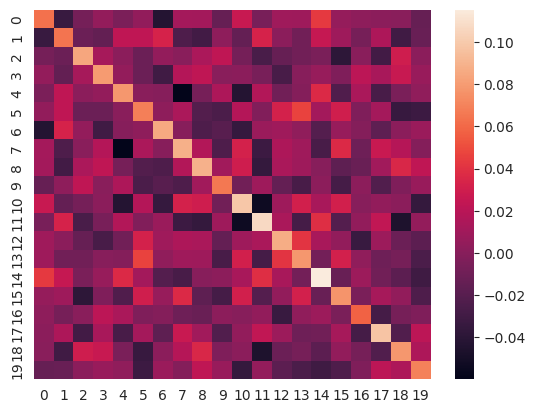

In [21]:
import seaborn as sns

sns.heatmap(cov1)

In [2]:
print("hello world")
print("This is a test")

hello world
This is a test


In [4]:
import numpy as np
a = np.arange(10)
b = np.arange(10)

c = a[:, None]*b[:, None]
print(c)

[[ 0]
 [ 1]
 [ 4]
 [ 9]
 [16]
 [25]
 [36]
 [49]
 [64]
 [81]]


In [9]:
a = 20
print(a//7)

2
